In [1]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from matplotlib import pyplot as plt

In [64]:
#parameter
waggle_angle = 0 # 0° nach oben, ccw
waggle_divergence = 29.2667 * np.pi / 180 #default im paper: 32°
waggle_divergence = 25 * np.pi / 180 #default im paper: 32°
waggle_speed = 15.04 # in mm/s vortrieb des waggle runs
waggle_duration = 1462 # in ms
waggle_freq = 13 # in Hz
waggle_amp_a = 5.9 * np.pi / 180 # in [0,2*pi] #hier peak to baseline angeben!!!
return_speed = 20.1 # in mm/s
return_duration = 2130 # in ms
exc  = 22
waggle_ramp_length = 150 #[ms]
 
resampling_steps = 700
resampling_coeff = resampling_steps / return_duration #steps per millisecond

In [65]:
#Definition of the orientation function, this three polynome give us the orientation and speed 
orientation_polynomial_coef = np.array([0.8562, -3.572, 7.517, -4.581]) * resampling_coeff
orientation_function = Polynomial(orientation_polynomial_coef) # return_orientation_function

velocityX_polynomial_coef = np.array([0.03409, -0.1805, 0.9225, -1.466, 0.728]) * resampling_coeff
velocityX_function = Polynomial(velocityX_polynomial_coef) # return_velocityX_function

velocityY_polynomial_coef = np.array([-0.0337, 0.1027, -0.04566, -0.2951, 0.2683]) * resampling_coeff
velocityY_function = Polynomial(velocityY_polynomial_coef) # return_velocityY_function

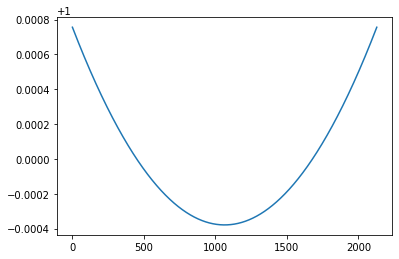

In [66]:
# ?????
t=np.linspace(0,1,return_duration)
alpha = np.exp(10)/100
return_orientation_weights = ((((t-0.5)**2)+alpha))
return_orientation_weights = return_orientation_weights / ((np.sum(return_orientation_weights) / return_duration))
plt.figure()
plt.plot(return_orientation_weights)
plt.show()

# Return a scale for orientation
t = np.linspace(0,1,return_duration)
f = orientation_function(t)
turn_scale = (360-(waggle_divergence/2)*180/np.pi)/sum(f)

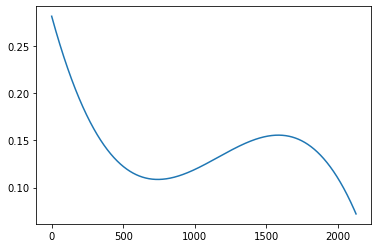

In [67]:
plt.figure()
plt.plot(orientation_function(t) ** return_orientation_weights)
plt.show()

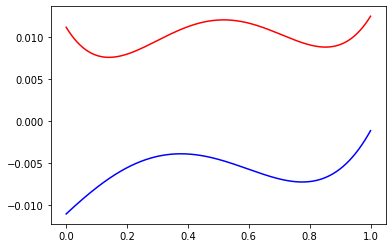

In [68]:
plt.figure()
plt.plot(t, velocityX_function(t), 'r-', t, velocityY_function(t), 'b-')

In [69]:
def getWaggleVelocity(t, left):
    v = np.array([0., 0., 0.])
    num_periods = ((waggle_duration/1000)*waggle_freq)
    sample_points_for_one_period = 1000 / waggle_freq
    
    if left:
        sign = 1
    else:
        sign = -1
    
    ramp = 1
    num_periods = (waggle_duration/1000.0) * waggle_freq
    sample_points_for_one_period = 1000.0 / waggle_freq
    
    if t < sample_points_for_one_period : 
        ramp = t / sample_points_for_one_period
    else:
        if t > (sample_points_for_one_period * (num_periods - 1)) :
            ramp = (waggle_duration - t) / sample_points_for_one_period
            
    t_prcnt = (t/waggle_duration)
    num_periods = ((waggle_duration/1000)*waggle_freq)
    
    v[0] = waggle_speed * np.cos(waggle_angle + sign*waggle_divergence/2) / 1000
    v[1] = waggle_speed * np.sin(waggle_angle + sign*waggle_divergence/2) / 1000
    v[2] = waggle_amp_a * ramp * np.cos(num_periods * t_prcnt * 2 * np.pi) / (1000 / (waggle_freq * 4) / (np.pi*0.5))

    return v

In [70]:
def getReturnVelocity(t, Ocur, left):
    v = np.array([0., 0., 0.])
    
    if left:
        sign = 1
    else:
        sign = -1
    
    ramp = 1;
    d = 100;
    if t < d:
        ramp = t / d;

    unit_t = t / return_duration;
    v[2] = return_orientation_weights[int(min(return_duration, np.floor(t)+1))] * turn_scale*sign*ramp*np.pi*orientation_function(unit_t)/180
        
    v_fwd = turn_scale*ramp*velocityX_function(unit_t)
    v_swd = turn_scale*ramp*sign*velocityY_function(unit_t)
    
    c = np.cos(Ocur)
    s = np.sin(Ocur)
    
    v[0] = c*v_fwd - s*v_swd # + exc*(np.cos(Ocur+v[2])-np.cos(Ocur))
    v[1] = s*v_fwd + c*v_swd # + exc*(np.sin(Ocur+v[2])-np.sin(Ocur))
    return v

In [77]:
current_position = np.array([0, 0, waggle_divergence/2])
position = current_position

#for t in range(0, waggle_duration):
#    q = getWaggleVelocity(t, True)
#    current_position = current_position + q
#    position = np.vstack([position, current_position])
    
x_i = current_position[0]
y_i = current_position[1]
print(y_i)

for t in range(0, return_duration-1):
    q = getReturnVelocity(t, current_position[2], True)
    current_position = current_position + q
    position = np.vstack([position, current_position])

#print(current_position[1])
    
#for t in range(0, waggle_duration):
#    q = getWaggleVelocity(t, False)
#    current_position = current_position + q
#    position = np.vstack([position, current_position])
    
#for t in range(0, return_duration-1):
#    q = getReturnVelocity(t, current_position[2], False)
#    current_position = current_position + q
#    position = np.vstack([position, current_position])

0.0


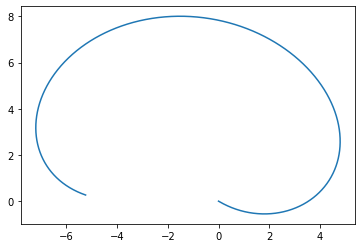

In [78]:
plt.plot(position[:,0], position[:,1])

# End of Tim program begining of mine

## Rescaling x and y to arrive to (-5.0, 0)

In [81]:
x_wanted = -5.0
y_wanted = 0.
position_rescaled = np.array(position)

x_delta = (position[-1, 0] - x_wanted)
x_deltadelta = x_delta / position.shape[0] 
print(position.shape[0])
for i in range(position.shape[0]):
    position_rescaled[i, 0] = position[i, 0] - i * x_deltadelta

y_delta = (position[-1, 1] - y_wanted)
y_deltadelta = y_delta / position.shape[0]
for i in range(position.shape[0]):
    position_rescaled[i, 1] = position[i, 1] - i * y_deltadelta

position_rescaled[-1,0:2] = [x_wanted, y_wanted]

2130


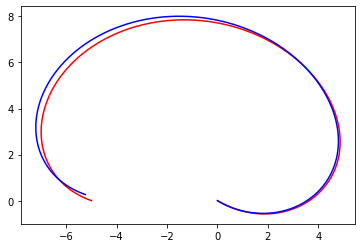

In [82]:
plt.plot(position_rescaled[:,0], position_rescaled[:,1], '-r', position[:,0], position[:,1], '-b')

In [56]:
print(position[0,:])
print(position_rescaled[0,:])

print(position[-1,:])
print(position_rescaled[-1,:])

[0.         0.         0.21816616]
[0.         0.         0.21816616]
[-5.24598962  0.26582448  6.01486245]
[-10.           0.           6.01486245]
